### 🔍 Anotações e Classes
Anotação batimento a batimento: Cada batimento cardíaco é anotado com:
- Tipo de batimento (classe)
- Localização temporal (sample)
- Informação auxiliar (marca de ruído, pausa, etc.)

### Principais classes de batimentos
Conforme a AAMI EC57 standard, os batimentos são frequentemente agrupados em:
- N: Batimentos normais
- S: Batimentos atriais (supraventriculares)
- V: Batimentos ventriculares
- F: Batimentos de fusão
- Q: Batimentos desconhecidos (ruídos, artefatos, etc.)

### Exemplos de rótulos específicos:
- N: Normal beat
- L: Left bundle branch block beat
- R: Right bundle branch block beat
- A: Atrial premature beat
- V: Premature ventricular contraction
- F: Fusion of ventricular and normal beat
- e, j, /, x, etc.: Outras anotações específicas ou ruídos

### Formatos de arquivo
- .dat: Sinais brutos em formato binário
- .hea: Arquivo de cabeçalho com metadados (ex: canais, frequências)
- .atr: Arquivos com anotações (batimentos e eventos)

### Ferramentas recomendadas para leitura:
- WFDB (WaveForm DataBase) toolkit
- Bibliotecas Python como wfdb e biosppy

### Dataset:
MIT-BIH:
- https://www.physionet.org/content/mitdb/1.0.0/

In [13]:
# Importando bibliotecas
import wfdb
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
# Função para imprimir um intervalo de x segundos do eletrocardiograma
def plot_ecg(nome_registro, sinal_ecg, fs, duracao, n_amostras, filter=None):
    # Recorte do sinal e do tempo
    sinal_ds = sinal_ecg[:n_amostras]
    tempo_ds = np.arange(n_amostras) / fs

    # atualizando título para caso queira descrever o filtro utilizado
    titulo = f'ECG do Paciente {nome_registro} - MLII ({duracao} segundos)'
    if filter != None:
        titulo += f' [{filter} filter]'

    # Plotando dados
    plt.figure(figsize=(12, 4))
    plt.plot(tempo_ds, sinal_ds)
    plt.title(titulo)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
# Filtro passa banda
def band_pass(ecg, fs):
    W1 = 5*2/fs
    W2 = 15*2/fs
    b, a = signal.butter(4, [W1,W2], 'bandpass') # definindo parametros
    ecg_bp = signal.filtfilt(b,a,np.transpose(ecg)) # implementando filtro

    return ecg_bp

In [5]:
# Etapa de Diferenciação e elevação ao quadrado do sinal
def differentiate(ecg):
    ecg_df = np.diff(ecg)
    ecg_sq = np.power(ecg_df, 2)
    return np.insert(ecg_sq,0,ecg_sq[0]) # para manter o tamanho do array

In [6]:
# Código do paciente
nome_registro = "100"
base_de_dados = "mitdb"

try:
    registro = wfdb.rdrecord(nome_registro, pn_dir=base_de_dados)
    anotacoes = wfdb.rdann(nome_registro, 'atr', pn_dir=base_de_dados)

    print(f"registro = {registro}")
    print(f"anotacoes = {anotacoes}")
except FileNotFoundError:
    print(f"Arquivo não encontrado: {nome_registro}")
except Exception as e:
    print(f"Erro: {e}")

registro = <wfdb.io.record.Record object at 0x00000275445991C0>
anotacoes = <wfdb.io.annotation.Annotation object at 0x00000275445169F0>


In [7]:
print(f"Paciente: {registro.record_name}")
print(f"Duração: {registro.sig_len / registro.fs:.2f} segundos")
print(f"Número de canais: {registro.n_sig}")
print(f"Canais: {registro.sig_name}")
print(f"Frequência de amostragem: {registro.fs} Hz")
print(f"Unidades: {registro.units}")
print(f"Ganho do ADC: {registro.adc_gain}")
print(f"Resolução do ADC: {registro.adc_res} bits")

# Comentários clínicos (às vezes contém idade, sexo, etc.)
if registro.comments:
    print("\nComentários:")
    for c in registro.comments:
        print("-", c)

Paciente: 100
Duração: 1805.56 segundos
Número de canais: 2
Canais: ['MLII', 'V5']
Frequência de amostragem: 360 Hz
Unidades: ['mV', 'mV']
Ganho do ADC: [200.0, 200.0]
Resolução do ADC: [11, 11] bits

Comentários:
- 69 M 1085 1629 x1
- Aldomet, Inderal


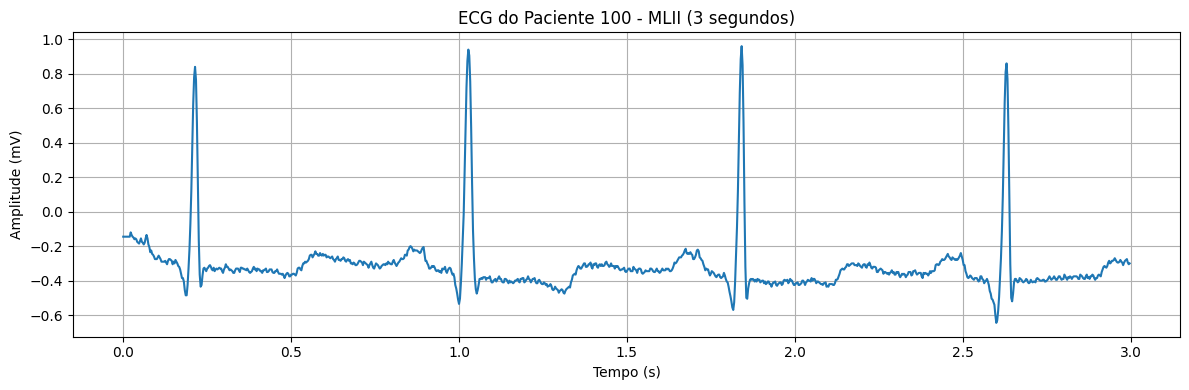

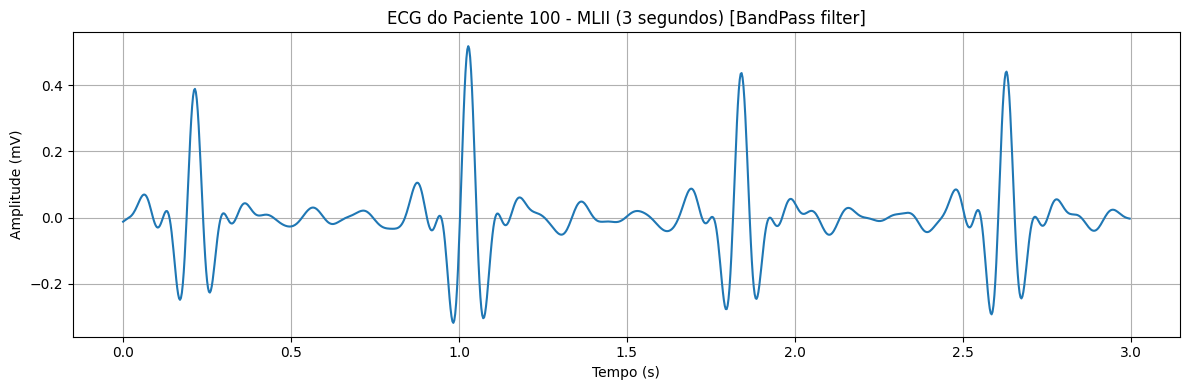

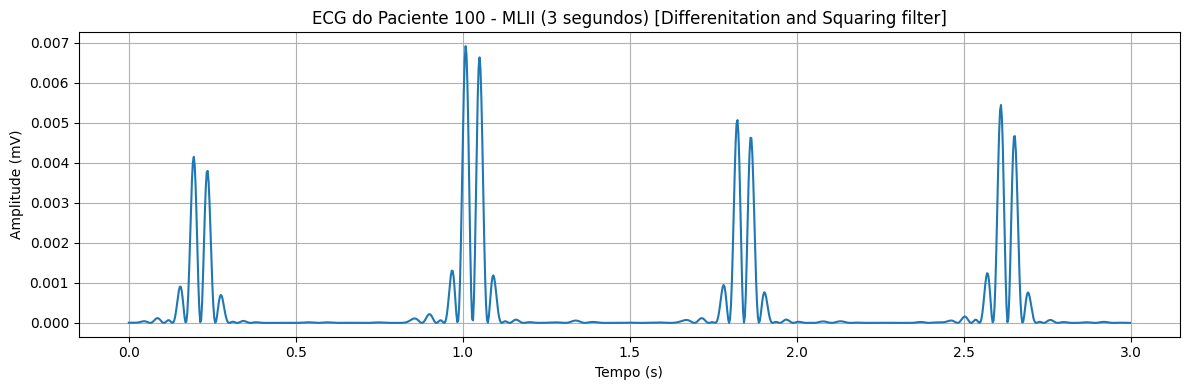

In [8]:
# Carregando o sinal do ecg [canal 0: "MLII"] e sua frequência de amostragem
sinal_ecg = registro.p_signal[:, 0]
fs = registro.fs

# Duração desejada em segundos
duracao = 3
n_amostras = int(fs * duracao)

# Aplicando etapas do Pan-Tompkins
bp_sinal_ecg = band_pass(sinal_ecg, fs)
dif_sinal_ecg = differentiate(bp_sinal_ecg)

# Plotando sinais
plot_ecg(nome_registro, sinal_ecg, fs, duracao, n_amostras)
plot_ecg(nome_registro, bp_sinal_ecg, fs, duracao, n_amostras, filter="BandPass")
plot_ecg(nome_registro, dif_sinal_ecg, fs, duracao, n_amostras, filter="Differenitation and Squaring")

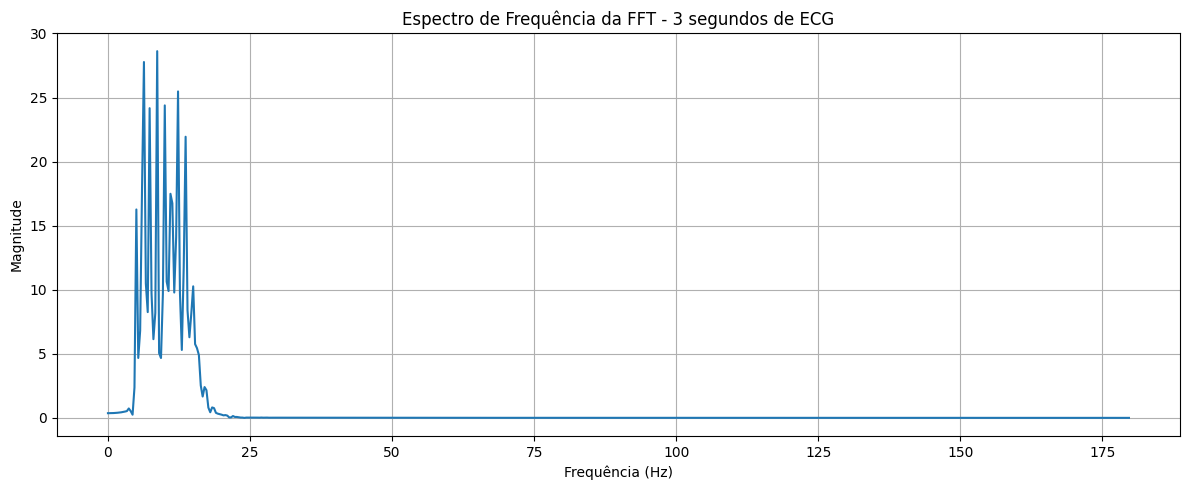

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft_ecg(sinal, fs, duracao):
    """
    Plota o espectro de frequência do sinal usando FFT.
    
    sinal: vetor do sinal (ex: bp_sinal_ecg)
    fs: frequência de amostragem (Hz)
    duracao: duração do sinal (segundos) que será considerado
    """
    n_amostras = int(fs * duracao)
    sinal_ds = sinal[:n_amostras]
    
    # Calcula FFT
    fft_sinal = np.fft.fft(sinal_ds)
    
    # Frequências correspondentes
    freqs = np.fft.fftfreq(n_amostras, d=1/fs)
    
    # Apenas parte positiva do espectro (frequências positivas)
    idx_positivas = freqs >= 0
    
    plt.figure(figsize=(12, 5))
    plt.plot(freqs[idx_positivas], np.abs(fft_sinal[idx_positivas]))
    plt.title(f'Espectro de Frequência da FFT - {duracao} segundos de ECG')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exemplo de uso (coloque abaixo do seu código já executado)
plot_fft_ecg(bp_sinal_ecg, fs, duracao)